In [1]:
%load_ext autoreload
%autoreload 2

import numpy
from matplotlib import pyplot

import calibr8

### Planning calibration series
For the best modeling results, it is recommended to acquire evenly spaced calibration points.

With `calibr8.utils.DilutionPlan` you can automagically generate pipetting instructions for making such a dilution series.

You'll need to specify a few parameters:

In [2]:
help(calibr8.utils.DilutionPlan.__init__)

Help on function __init__ in module calibr8.utils:

__init__(self, *, xmin:float, xmax:float, R:int, C:int, stock:float, mode:str, vmax:float, min_transfer:float)
    Plans a regularly-spaced dilution series with in very few steps.
    
    Args:
        xmin (float): lowest concentration value in the result
        xmax (float): highest concentration in the result
        R (int): number of rows in the MTP
        C (int): number of colums in the MTP
        stock (float): stock concentration (must be >= xmax)
        mode (str): either 'log' or 'linear'
        vmax (float): maximum possible volume in the MTP
        min_transfer (float): minimum allowed volume for transfer steps



In [3]:
plan = calibr8.utils.DilutionPlan(
    xmin=0.001, xmax=30,
    R=8, C=12,
    stock=30,
    mode='log',
    vmax=1000,
    min_transfer=20
)

plan

Serial dilution plan (0.00101 to 30.00) from at least 9422.0 µl stock:
	Prepare column 1 with [1000.  897.  805.  722.  648.  581.  521.  468.] µl from stock
	Prepare column 2 with [420. 377. 338. 303. 272. 244. 219. 196.] µl from stock
	Prepare column 3 with [176. 158. 142. 127. 114. 102.  92.  82.] µl from stock
	Prepare column 4 with [74. 66. 60. 53. 48. 43. 39. 35.] µl from stock
	Prepare column 5 with [32. 32. 32. 32. 32. 32. 32. 32.] µl from column 0 (1 serial dilutions)
	Prepare column 6 with [32. 32. 32. 32. 32. 32. 32. 32.] µl from column 1 (1 serial dilutions)
	Prepare column 7 with [32. 32. 31. 32. 32. 32. 31. 32.] µl from column 2 (1 serial dilutions)
	Prepare column 8 with [32. 32. 31. 32. 31. 32. 31. 31.] µl from column 3 (1 serial dilutions)
	Prepare column 9 with [31. 31. 31. 31. 31. 31. 31. 31.] µl from column 4 (2 serial dilutions)
	Prepare column 10 with [31. 31. 31. 31. 31. 31. 31. 31.] µl from column 5 (2 serial dilutions)
	Prepare column 11 with [31. 31. 32. 31. 3

As you can see from the output above, the instructions were generated such that only integer µl volumes greater than the `min_transfer` volume are used.
Also, the number of serial dilution steps is minimized to reduce pipetting error.

The instructions are also machine readable. In the `DilutionPlan.instructions` attribute, you can find a list of tuples `(c, dsteps, src, v)`:
+ `c`: number of the column (0-based)
+ `dsteps`: number of serial dilution steps that were required to make the column
+ `src`: source to prepare the column from (either `'stock'` or 0-based column number)
+ `v`: transfer volumes for preparing the column

Due to rounding, the resulting concentrations (`DilutionPlan.x`) are not perfect, but they deviate from the ideal. In the following plot you can see the spacing, column-association (color) and also deviations from the ideal concentrations.

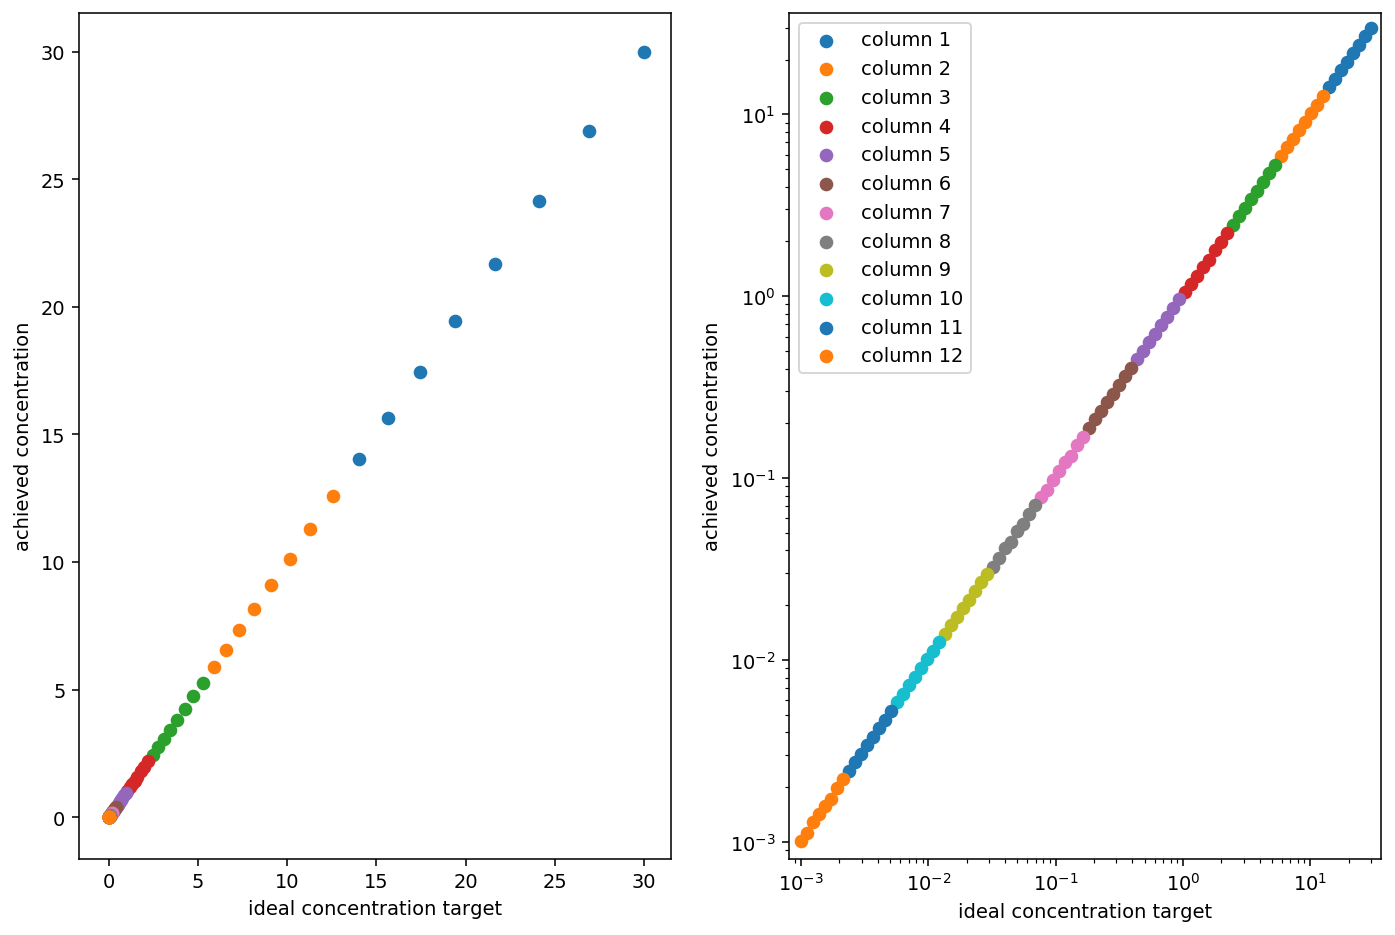

In [4]:
fig, (left, right) = pyplot.subplots(ncols=2, figsize=(12, 8), dpi=140)

for c in range(plan.C):
    x = plan.ideal_x[:,c]
    y = plan.x[:,c]
    left.scatter(x.flatten('F'), y.flatten('F'))
    right.scatter(x.flatten('F'), y.flatten('F'), label=f'column {c+1}')
right.set_xscale('log')
right.set_yscale('log')
right.set_xlim(plan.xmin*0.8, plan.xmax*1.2)
right.set_ylim(plan.xmin*0.8, plan.xmax*1.2)

left.set_xlabel('ideal concentration target')
left.set_ylabel('achieved concentration')
right.set_xlabel('ideal concentration target')
right.set_ylabel('achieved concentration')

right.legend()

pyplot.show()

In [5]:
max_relative_error = numpy.abs(1 - plan.x / plan.ideal_x).max()
print(f'The resulting concentrations deviate from the ideal concentrations by <= {max_relative_error*100:.1f} %')

The resulting concentrations deviate from the ideal concentrations by <= 3.2 %
